# Projet Python data scientist 2A

## Classification de bières et rule mining autour d'un trajet de découverte des différentes variétés de bières

In [4]:
# Importation des modules nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### On commence par importer le dataset contenant 3 tables de données : l'une sur les bières, une sur les brasseries et une sur la qualité des bières, jugée par différents testeurs

On importe les données depuis kaggle : https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv

In [12]:
# Importation des données
beers = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\beers.csv') # Les bières
breweries = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\breweries.csv') # Les brasseries
reviews = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\archive\reviews.csv') # Les notes des bières

## Première analyse descriptive des données

In [26]:
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [38]:
print(len(beers.name.unique()))
print(len(beers.id.unique()))
beers.describe()

298567
358873
940


,id,brewery_id,abv
count,358873.000000,358873.000000,320076.000000
mean,189241.027199,24597.365051,6.528504
std,107675.746916,16442.976904,2.085403
min,3.000000,1.000000,0.010000
25%,96422.000000,7318.000000,5.000000
50%,189909.000000,28383.000000,6.000000
75%,282546.000000,37452.000000,7.500000
max,374406.000000,54144.000000,100.000000


### Remarques générales sur la table 'beers'
- On a une grande quantité de données, ce qui devrait faciliter la phase de nettoyage de celles-ci
- La colonne 'abv' correspond au pourcentage alcoolique des bières. La valeur max à 100 est donc impossible et cela onne un premier axe de nettoyage des données. La moyene est à 6.5 ce qui n'est pas aberrant. Les valeurs à exclure doivent donc être limitées.
- On a plus d'id distincts que de noms de bières. Soit un deuxième axe de nettoyage à prévoir

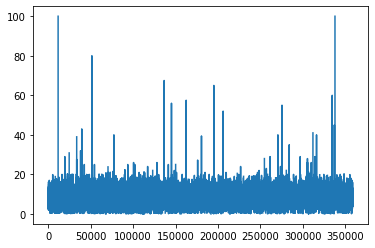

            id         name  brewery_id state country               style  \
136634  104620  Snake Venom       30178   GB6      GB  British Barleywine   

                  availability   abv  \
136634   Limited (brewed once)  67.5   

                                                    notes retired  
136634  Snake Venom is the world’s strongest beer as o...       t  


,id,name,brewery_id,state,country,style,availability,abv,notes,retired
11583,368014,Earache: World's Shortest Album,8396,GB2,GB,Winter Warmer,Year-round,100.0,No notes at this time.,f
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),80.0,No notes at this time.,f
313867,368012,Radiohead - OK Computer,8396,GB2,GB,Smoke Beer,Year-round,100.0,No notes at this time.,f
338025,365307,water,25916,AL,US,German Altbier,Rotating,100.0,No notes at this time.,f


In [46]:
fig = beers.abv.plot()
plt.show()
print(beers[beers.name == 'Snake Venom'])
beers[beers['abv'] > 67.5] #La bière la plus forte du monde est la Snake Venom à 67.5 %. 

Le graphique sur les pourcentages alcooliques 'abv' montre que les bières avec valeur aberrantes (abv > 67.5, la bière la plus forte du monde, la snake venom, émarge à 67.5 %) sont au nombre 4. La première, la 'Dark Reconing', est une erreur. Sur le site de la brasserie, on voit que l'abv de cette bière est en fait de 5.9 %. Nous allons corriger cette valeur pour la suite.
\n
Les trois autres bières qui émargent à 100 % sont des anomalies volontaires, des blagues qui correspondent à de l'eau, et deux album de Rock. On les retire de la table pour la suite.

In [100]:
beers.reset_index
beers.set_index('id')
beers.where(beers.id == 311921).abv = 5.9
beers[beers['abv'] > 67.5]
# beers.drop(beers.loc[beers.abv > 8, inplace = True)

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
11583,368014,Earache: World's Shortest Album,8396,GB2,GB,Winter Warmer,Year-round,100.0,No notes at this time.,f
51390,311921,Dark Reckoning,47203,CA,US,American Porter,Limited (brewed once),80.0,No notes at this time.,f
313867,368012,Radiohead - OK Computer,8396,GB2,GB,Smoke Beer,Year-round,100.0,No notes at this time.,f
338025,365307,water,25916,AL,US,German Altbier,Rotating,100.0,No notes at this time.,f
